In [19]:

# -*- coding: utf-8 -*-
# 用 PageRank 挖掘希拉里邮件中的重要任务关系
import pandas as pd
import networkx as nx
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
# 数据加载
emails = pd.read_csv("./input/Emails.csv")
# 读取别名文件
Aliases = pd.read_csv("./input/Aliases.csv")
aliases = {}
for index, row in Aliases.iterrows():
    aliases[row['Alias']] = row['PersonId']
# 读取人名文件
Persons = pd.read_csv("./input/Persons.csv")
persons = {}
for index, row in Persons.iterrows(): 
    persons[row['Id']] = row['Name']
   

In [5]:
emails.head(2)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...


In [42]:
Persons.head(2)

,Id,Name
0,1,111th Congress
1,2,AGNA USEMB Kabul Afghanistan


In [9]:
Aliases.head(2)

,Id,Alias,PersonId
0,1,111th congress,1
1,2,agna usemb kabul afghanistan,2


In [24]:
# 针对别名进行转换 
def unify_name(name): 
    # 姓名统一小写 
    name = str(name).lower() 
    # 去掉, 和 @后面的内容 
    name = name.replace(",","").split("@")[0] 
    # 别名转换 
    if name in aliases.keys(): 
        return persons[aliases[name]] 
    return name

In [43]:
# 画网络图
def show_graph(graph, layout='spring_layout'): 
    # 使用 Spring Layout 布局，类似中心放射状 
    if layout == 'circular_layout': 
        positions=nx.circular_layout(graph) 
    else: 
        positions=nx.spring_layout(graph) 
    # 设置网络图中的节点大小，大小与 pagerank 值相关，因为 pagerank 值很小所以需要 *20000 
    nodesize = [x['pagerank']*20000 for v,x in graph.nodes(data=True)] 
    # 设置网络图中的边长度 
    edgesize = [np.sqrt(e[2]['weight']) for e in graph.edges(data=True)] 
    # 绘制节点 
    nx.draw_networkx_nodes(graph, positions, node_size=nodesize, alpha=0.4) 
    # 绘制边 
    nx.draw_networkx_edges(graph, positions, edge_size=edgesize, alpha=0.2) 
    # 绘制节点的  label 
    nx.draw_networkx_labels(graph, positions, font_size=10) 
    # 输出希拉里邮件中的所有人物关系图
    plt.show()

In [44]:
# 将寄件人和收件人的姓名进行规范化
emails.MetadataFrom = emails.MetadataFrom.apply(unify_name)
emails.MetadataTo = emails.MetadataTo.apply(unify_name)

In [49]:
# 设置遍的权重等于发邮件的次数
edges_weights_temp = defaultdict(list)
for row in zip(emails.MetadataFrom, emails.MetadataTo, emails.RawText): 
    temp = (row[0], row[1]) 
    if temp not in edges_weights_temp: 
        edges_weights_temp[temp] = 1 
    else: 
        edges_weights_temp[temp] = edges_weights_temp[temp] + 1

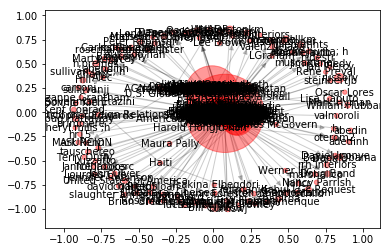

In [51]:
# 转化格式 (from, to), weight => from, to, 
weightedges_weights = [(key[0], key[1], val) for key, val in edges_weights_temp.items()]
# 创建一个有向图
graph = nx.DiGraph()
# 设置有向图中的路径及权重 (from, to, weight)
graph.add_weighted_edges_from(edges_weights)
# 计算每个节点（人）的 PR 值，并作为节点的 pagerank 属性
pagerank = nx.pagerank(graph)
# 将 pagerank 数值作为节点的属性
nx.set_node_attributes(graph, name = 'pagerank', values=pagerank)
# 画网络图
show_graph(graph)

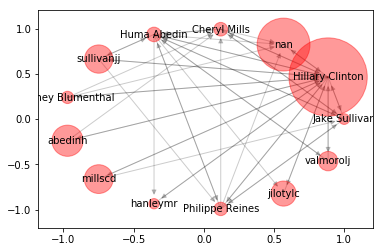

In [52]:
# 将完整的图谱进行精简# 设置 PR 值的阈值，筛选大于阈值的重要核心节点
pagerank_threshold = 0.005
# 复制一份计算好的网络图
small_graph = graph.copy()
# 剪掉 PR 值小于 pagerank_threshold 的节点
for n, p_rank in graph.nodes(data=True): 
    if p_rank['pagerank'] < pagerank_threshold: 
        small_graph.remove_node(n)
# 画网络图,采用circular_layout布局让筛选出来的点组成一个圆
show_graph(small_graph, 'circular_layout')